<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Ensemble_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageChops
from matplotlib.pyplot import imshow
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import random
import datetime
import shutil

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"
dataset_path = "/content/dataset/content/splitted_dataset"

Mounted at /content/drive/


# Data preparation

In [ ]:
training_dir = dataset_path + "/training_set"
test_dir = dataset_path + "/test_set"
validation_dir = dataset_path + "/validation_set"
kfold_dir = dataset_path + "/kfold_set"

labels = ['battery', 'organic', 'paper', 'metal', 'plastic', 'trash', 'clothes', 'glass']
a = 0
b = 0
c = 0
d = 0
for l in labels:
  a += len(os.listdir(training_dir + "/" + str(l)))
  b += len(os.listdir(validation_dir + "/" + str(l)))
  c += len(os.listdir(test_dir + "/" + str(l)))
  d += len(os.listdir(kfold_dir + "/" + str(l)))

print("Training samples are: " + str(a))
print("Validation samples are: " + str(b))
print("Test samples are: " + str(c))
print("Kfold samples are: " + str(d))

Training samples are: 7040
Validation samples are: 2327
Test samples are: 2328
Kfold samples are: 8528


In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT_RESNET = 224
IMAGE_WIDTH_RESNET = 224

IMAGE_HEIGHT_MOBILENET = 192
IMAGE_WIDTH_MOBILENET = 192

IMAGE_HEIGHT_VGG = 224
IMAGE_WIDTH_VGG = 224

IMAGE_HEIGHT_SCRATCH = 224
IMAGE_WIDTH_SCRATCH = 224


train_dataset = image_dataset_from_directory(
    training_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT_RESNET, IMAGE_WIDTH_RESNET),
    batch_size=BATCH_SIZE)

train_dataset_mnet = image_dataset_from_directory(
    training_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT_MOBILENET, IMAGE_WIDTH_MOBILENET),
    batch_size=BATCH_SIZE)

train_dataset_vgg = image_dataset_from_directory(
    training_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT_VGG, IMAGE_WIDTH_VGG),
    batch_size=BATCH_SIZE)

train_dataset_scratch = image_dataset_from_directory(
    training_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT_SCRATCH, IMAGE_WIDTH_SCRATCH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_RESNET, IMAGE_WIDTH_RESNET),
    batch_size=BATCH_SIZE)

validation_dataset_mnet = image_dataset_from_directory(
    validation_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_MOBILENET, IMAGE_WIDTH_MOBILENET),
    batch_size=BATCH_SIZE)

validation_dataset_vgg = image_dataset_from_directory(
    validation_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_VGG, IMAGE_WIDTH_VGG),
    batch_size=BATCH_SIZE)

validation_dataset_scratch = image_dataset_from_directory(
    validation_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_SCRATCH, IMAGE_WIDTH_SCRATCH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_RESNET, IMAGE_WIDTH_RESNET),
    batch_size=BATCH_SIZE)

test_dataset_mnet = image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_MOBILENET, IMAGE_WIDTH_MOBILENET),
    batch_size=BATCH_SIZE)

test_dataset_vgg = image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_VGG, IMAGE_WIDTH_VGG),
    batch_size=BATCH_SIZE)

test_dataset_scratch = image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_HEIGHT_SCRATCH, IMAGE_WIDTH_SCRATCH),
    batch_size=BATCH_SIZE)

kfold_dataset = image_dataset_from_directory(
    kfold_dir,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_HEIGHT_RESNET, IMAGE_WIDTH_RESNET),
    batch_size=BATCH_SIZE)


Found 7040 files belonging to 8 classes.
Found 7040 files belonging to 8 classes.
Found 7040 files belonging to 8 classes.
Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.
Found 8528 files belonging to 8 classes.


# Loading models and weights

In [ ]:
MODELS_DIR = "/content/drive/My Drive/models/"
resnet_model = tf.keras.models.load_model(MODELS_DIR + 'garbage_classification_pretrained_fine_tuned.h5')
vgg_model = tf.keras.models.load_model(MODELS_DIR + 'garbage_classification_pretrained_fine_tuned_VGG16.h5')
mobilenet_model = tf.keras.models.load_model(MODELS_DIR + 'checkpoint_mobilenet.h5')
scratch_model = tf.keras.models.load_model(MODELS_DIR + 'TwoDropout128Dense.h5')

# Testing of models

In [ ]:
vgg_test_scores = vgg_model.predict(test_dataset_vgg)
resnet_test_scores = resnet_model.predict(test_dataset)
mobilenet_test_scores = mobilenet_model.predict(test_dataset_mnet)
scratch_test_scores = scratch_model.predict(test_dataset_scratch)

73/73 [==============================] - 4s 44ms/step


In [ ]:
TRUE_TEST_LABELS = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
MODEL_TEST_SCORES = [vgg_test_scores, resnet_test_scores, mobilenet_test_scores, scratch_test_scores]

In [ ]:
vgg_val_scores = vgg_model.predict(validation_dataset_vgg)
resnet_val_scores = resnet_model.predict(validation_dataset)
mobilenet_val_scores = mobilenet_model.predict(validation_dataset_mnet)
scratch_val_scores = scratch_model.predict(validation_dataset_scratch)

73/73 [==============================] - 3s 46ms/step


In [ ]:
TRUE_VAL_LABELS = tf.concat([labels_batch for data_batch, labels_batch in validation_dataset], axis = 0)
MODEL_VAL_SCORES = [vgg_val_scores, resnet_val_scores, mobilenet_val_scores, scratch_val_scores]

# Average model

In [ ]:
ensemble_pred = []
n_models = len(MODEL_TEST_SCORES)
print(n_models)
print(MODEL_TEST_SCORES[0][1])
print(MODEL_TEST_SCORES[1][1])
print(MODEL_TEST_SCORES[2][1])
print(MODEL_TEST_SCORES[3][1])

for i in range(len(MODEL_TEST_SCORES[0])):
    x = (1/n_models) * (MODEL_TEST_SCORES[0][i] + MODEL_TEST_SCORES[1][i] + MODEL_TEST_SCORES[2][i] + MODEL_TEST_SCORES[3][i])
    ensemble_pred.append(np.argmax(x))

4
[1. 0. 0. 0. 0. 0. 0. 0.]
[1.0000000e+00 1.1758321e-11 9.5131923e-12 1.0190234e-11 3.8235764e-12
 4.2648446e-10 4.4175020e-12 9.7073849e-10]
[9.9987257e-01 1.7746095e-07 7.0499212e-08 1.2525552e-04 5.8031898e-08
 1.7394940e-07 6.4650942e-07 1.1508405e-06]
[9.7204643e-01 5.7877218e-03 1.2727774e-02 9.8112167e-04 3.1412710e-04
 1.3699458e-03 4.6441141e-03 2.1287291e-03]


In [ ]:
print(MODEL_TEST_SCORES[0][2])
print(MODEL_TEST_SCORES[1][2])
print(MODEL_TEST_SCORES[2][2])
print(MODEL_TEST_SCORES[3][2])

[1.0000000e+00 5.3916834e-20 3.7271078e-21 4.7904581e-18 1.1452764e-24
 2.7946558e-17 2.7872974e-18 1.9927574e-20]
[9.9999940e-01 9.3480264e-09 2.6280731e-11 1.5550436e-10 1.5812796e-11
 1.0698306e-08 5.5189349e-07 3.8002465e-10]
[9.9996471e-01 1.0245452e-08 1.1616131e-08 1.1500047e-07 1.6493672e-08
 1.4099454e-05 1.3273347e-05 7.7341565e-06]
[3.7076589e-01 3.2071199e-03 4.2672842e-04 2.2873102e-02 9.3571628e-03
 1.9239975e-03 5.7068801e-01 2.0757953e-02]


# Performances evaluation

Classification report: 
              precision    recall  f1-score   support

           0     0.9597    0.9754    0.9675       122
           1     0.9982    0.9954    0.9968      1095
           2     0.9652    0.9142    0.9390       303
           3     0.8864    0.9435    0.9141       124
           4     0.9613    0.9933    0.9770       150
           5     0.9864    0.9798    0.9831       297
           6     0.8672    0.9174    0.8916       121
           7     0.9826    0.9741    0.9784       116

    accuracy                         0.9738      2328
   macro avg     0.9509    0.9617    0.9559      2328
weighted avg     0.9744    0.9738    0.9739      2328



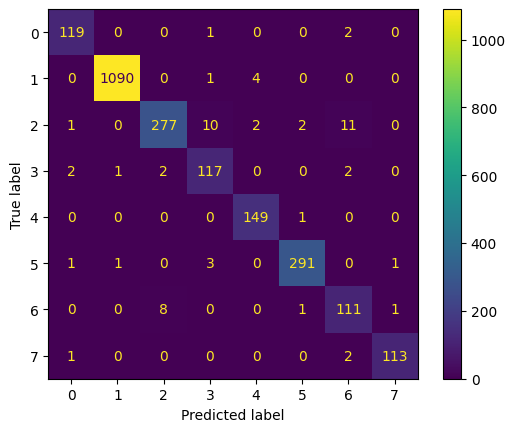

In [ ]:
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
print("Classification report: ")
print(metrics.classification_report(y_true.numpy().argmax(axis=1), ensemble_pred, digits = 4))
metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), ensemble_pred)